### 使用opensmile提取音频特征

In [1]:
import opensmile
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 1、构造特征提取函数

In [3]:
def extract_audio_feature(file):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals
    )
    y = smile.process_file(file)
    y = y.to_numpy().reshape(-1)
    return y

def extract_features_parallel(file_list, max_workers=85):
    features = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_file = {executor.submit(extract_audio_feature, file): file for file in file_list}
        for future in tqdm(as_completed(future_to_file), total=len(file_list), desc="Extracting features"):
            file = future_to_file[future]
            try:
                feature = future.result()
                features.append(feature)
            except Exception as exc:
                print(f'{file} generated an exception: {exc}')
    features = np.stack(features, axis=0)
    return features

In [4]:
# 示例使用
file_list = ["./train/Ses01F_impro01_F000.wav", "./train/Ses01F_impro01_F001.wav"]
features = extract_features_parallel(file_list, max_workers=4)
print(features.shape)

Extracting features: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]

(2, 88)


## 2、csv文件读入示例

In [5]:
## 读入csv文件示例
## 由于我们的csv文件使用"#"分隔，需要定义sep参数为"#",否则会读取失败！！！
train_csv = pd.read_csv("./CSVfile/train.csv",sep="#")

In [6]:
## 快速查看前5条数据
train_csv.head(5)

,num,id,path,text,label
0,1,Ses01F_impro01_F000,train/Ses01F_impro01_F000.wav,Excuse me.,2
1,2,Ses01F_impro01_F001,train/Ses01F_impro01_F001.wav,Yeah.,2
2,3,Ses01F_impro01_F002,train/Ses01F_impro01_F002.wav,Is there a problem?,2
3,4,Ses01F_impro01_F005,train/Ses01F_impro01_F005.wav,Well what's the problem? Let me change it.,2
4,5,Ses01F_impro01_F012,train/Ses01F_impro01_F012.wav,That's out of control.,0


In [7]:
## 统计该csv下lable列不同值的数量
train_csv.value_counts(subset="label")

label
2    1066
1     891
3     696
0     606
Name: count, dtype: int64

Text(0.5, 1.0, 'Train dataset sample distribution')

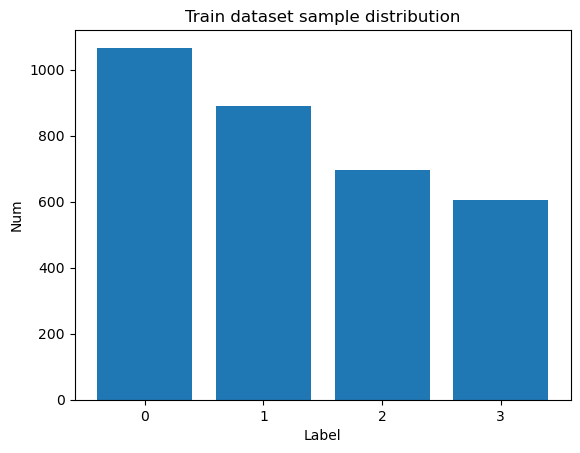

In [8]:
## 画图显示类别数
plt.bar([0,1,2,3],list(train_csv.value_counts(subset="label")),tick_label = ["0","1","2","3"])
plt.xlabel("Label")
plt.ylabel("Num")
plt.title("Train dataset sample distribution")

## 3、性能指标函数

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [10]:
def calculate_score_classification(preds, labels, average_f1='macro'):  # weighted, macro
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average=average_f1, zero_division=0)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    ua = recall_score(labels, preds, average='macro', zero_division=0)
    confuse_matrix = confusion_matrix(labels, preds)
    return accuracy, ua, f1, precision, confuse_matrix

### 4、构造机器学习模型

### SVM

In [11]:
# from sklearn.svm import SVC
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

# class MySVM:
#     def __init__(self):
#         self.model = Pipeline([
#             ('scaler', StandardScaler()),
#             ('svm', SVC(C=100, kernel='rbf', gamma='scale', probability=True))
#         ])

#     def train(self, X, y):
#         self.model.fit(X, y)

#     def predict_proba(self, X):
#         return self.model.predict_proba(X)

#     def predict(self, X):
#         return self.model.predict(X)

#     def evaluate(self, X, y):
#         preds = self.predict(X)
#         accuracy = accuracy_score(y, preds)
#         ua = recall_score(y, preds, average='macro')
#         f1 = f1_score(y, preds, average='macro')
#         precision = precision_score(y, preds, average='macro')
#         confuse_matrix = confusion_matrix(y, preds)
#         return accuracy, ua, f1, precision, confuse_matrix

### RF

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)


class MyRandomForest:
    def __init__(self):
        self.model = RandomForestClassifier(
            n_estimators=200,  # 增加树的数量
            random_state=42,
            criterion="entropy",
            max_depth=4,  # 限制树的最大深度
            max_features="log2",  # 限制每棵树在分裂时考虑的特征数量
            class_weight="balanced",
            min_samples_split=10,  # 设置分裂所需的最小样本数
            min_samples_leaf=4,  # 设置叶节点所需的最小样本数
        )

    def train(self, X, y):
        self.model.fit(X, y)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, y):
        preds = self.predict(X)
        accuracy = accuracy_score(y, preds)
        ua = recall_score(y, preds, average="macro")
        f1 = f1_score(y, preds, average="macro")
        precision = precision_score(y, preds, average="macro")
        confuse_matrix = confusion_matrix(y, preds)
        return accuracy, ua, f1, precision, confuse_matrix

### KNN

### Naive Bayes

### MLP

### LR

In [13]:
# from sklearn.linear_model import LogisticRegression


# class MyLogisticRegression:
#     def __init__(self):
#         self.model = LogisticRegression(
#             max_iter=100000000-1, solver="lbfgs", C=100.0, multi_class="ovr"
#         )
#         self.losses = []

#     def train(self, X, y):
#         self.model.fit(X, y)

#         probs = self.model.predict_proba(X)
#         loss = -np.mean(
#             y * np.log(probs[:, 1] + 1e-5) + (1 - y) * np.log(1 - probs[:, 1] + 1e-5)
#         )
#         self.losses.append(loss)

#     def predict_proba(self, X):
#         return self.model.predict_proba(X)

#     def predict(self, X):
#         return self.model.predict(X)

#     def evaluate(self, X, y):
#         preds = self.predict(X)
#         accuracy, ua, f1, precision, confuse_matrix = calculate_score_classification(
#             preds, y
#         )
#         return accuracy, ua, f1, precision, confuse_matrix

#     def plot_losses(self):
#         plt.figure()
#         plt.plot(range(1, len(self.losses) + 1), self.losses)
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.title("Training Loss Curve")
#         plt.show()

## 5、读取csv文件，分离音频文件路径、标签

In [14]:
## 读取train.csv、dev.csv
train_csv = pd.read_csv("./CSVfile/train.csv", sep = "#")
dev_csv = pd.read_csv("./CSVfile/dev.csv", sep = "#")

train_path = np.array(list(train_csv.path))
train_label = np.array(list(train_csv.label))
dev_path = np.array(list(dev_csv.path))
dev_label = np.array(list(dev_csv.label))

## 6、结果写入函数

In [15]:
## test_preds 长度为1241的list，对应测试集中1241个样本的标签
##运行后会在当前目录生成result.csv文件，提交result.csv文件即可
##如果没有生成，请检查test_preds的长度是否为1241！

def write_result(test_preds, res_name):
    if len(test_preds) != 1241:
        print("错误！请检查test_preds长度是否为1241！！！")
        return -1
    test_csv = pd.read_csv("./CSVfile/test.csv", sep="#")
    test_csv["label"] = list(tqdm(test_preds, desc="Writing results"))
    res_name = './result_' + res_name + '.csv'
    test_csv.to_csv(res_name, sep="#")
    print("测试集预测结果已成功写入到文件中！")


## 7、特征预处理函数、主函数

In [16]:
file_list = os.listdir("./train")
file_list = ["./train/" + file for file in file_list]
train_feature = extract_features_parallel(file_list, max_workers=85)

Extracting features:   0%|          | 0/3259 [00:00<?, ?it/s]

Extracting features: 100%|██████████| 3259/3259 [01:18<00:00, 41.67it/s] 


In [17]:
print(train_feature.shape)

(3259, 88)


In [18]:
save_train_feature = train_feature

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler()
train_feature_normalized = min_max_scaler.fit_transform(train_feature)
train_feature = train_feature_normalized

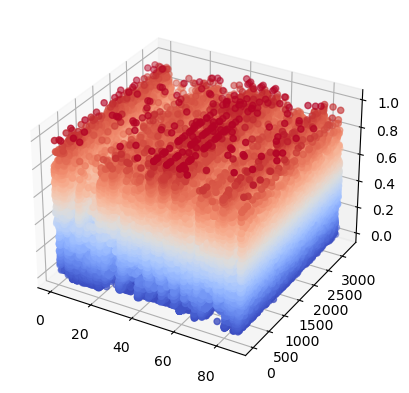

In [20]:
# print(train_feature)

rows, cols = train_feature.shape
x, y = np.meshgrid(range(cols), range(rows))
x = x.flatten()
y = y.flatten()
z = train_feature.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='coolwarm')
plt.show()

### LR

In [21]:
# print("LR training...")
# lr = MyLogisticRegression()
# lr.train(train_feature, train_label)
# train_preds = lr.predict(train_feature)
# tran_acc, tran_ua, tran_f1, tran_pre, confuse_matrix = lr.evaluate(train_feature, train_label)
# print(f"Train:\nAcc:{tran_acc} \nUa:{tran_ua} \nMacro_F1:{tran_f1} \nPre:{tran_pre}\nConfuse_matrix:\n{confuse_matrix}\n")

# lr.plot_losses()

# dev_file_list = os.listdir("./dev")
# dev_file_list = [os.path.join("./dev", file) for file in dev_file_list]
# dev_feature = extract_features_parallel(dev_file_list, max_workers=85)
# dev_acc, dev_ua, dev_f1, dev_pre, confuse_matrix = lr.evaluate(dev_feature, dev_label)
# print(f"Dev:\nAcc:{dev_acc} \nUa:{dev_ua} \nMacro_F1:{dev_f1} \nPre:{dev_pre}\nConfuse_matrix:\n{confuse_matrix}\n")

# test_csv = pd.read_csv("./CSVfile/test.csv", sep="#")
# test_path = list(test_csv.path)
# test_path = [os.path.join("./", file) for file in test_path]
# test_feature = extract_features_parallel(test_path, max_workers=85)
# test_label = lr.predict(test_feature)
# test_preds = test_label
# print(len(test_feature))

# write_result(test_preds, "lr")

### SVM

In [22]:
# print("SVM training...")
# svm = MySVM()
# svm.train(train_feature, train_label)

# # 训练集性能
# train_preds = svm.predict(train_feature)
# train_acc, train_ua, train_f1, train_pre, train_confuse_matrix = svm.evaluate(train_feature, train_label)
# print(f"Train:\nAcc:{train_acc} \nUa:{train_ua} \nMacro_F1:{train_f1} \nPre:{train_pre}\nConfuse_matrix:\n{train_confuse_matrix}\n")

# # 验证集性能
# dev_file_list = os.listdir("./dev")
# dev_file_list = [os.path.join("./dev", file) for file in dev_file_list]
# dev_feature = extract_features_parallel(dev_file_list, max_workers=85)
# dev_acc, dev_ua, dev_f1, dev_pre, dev_confuse_matrix = svm.evaluate(dev_feature, dev_label)
# print(f"Dev:\nAcc:{dev_acc} \nUa:{dev_ua} \nMacro_F1:{dev_f1} \nPre:{dev_pre}\nConfuse_matrix:\n{dev_confuse_matrix}\n")

# # 测试集预测
# test_csv = pd.read_csv("./CSVfile/test.csv", sep="#")
# test_path = list(test_csv.path)
# test_path = [os.path.join("./", file) for file in test_path]
# test_feature = extract_features_parallel(test_path, max_workers=85)
# test_label = svm.predict(test_feature)
# test_preds = test_label
# print(len(test_feature))

# write_result(test_preds, "svm")

### RF

In [23]:
print("RF training...")
rf = MyRandomForest()
rf.train(train_feature, train_label)

# 训练集性能
train_preds = rf.predict(train_feature)
train_acc, train_ua, train_f1, train_pre, train_confuse_matrix = rf.evaluate(train_feature, train_label)
print(f"Train:\nAcc:{train_acc} \nUa:{train_ua} \nMacro_F1:{train_f1} \nPre:{train_pre}\nConfuse_matrix:\n{train_confuse_matrix}\n")

# 验证集性能
dev_file_list = os.listdir("./dev")
dev_file_list = [os.path.join("./dev", file) for file in dev_file_list]
dev_feature = extract_features_parallel(dev_file_list, max_workers=85)
dev_acc, dev_ua, dev_f1, dev_pre, dev_confuse_matrix = rf.evaluate(dev_feature, dev_label)
print(f"Dev:\nAcc:{dev_acc} \nUa:{dev_ua} \nMacro_F1:{dev_f1} \nPre:{dev_pre}\nConfuse_matrix:\n{dev_confuse_matrix}\n")

RF training...
Train:
Acc:0.4952439398588524 
Ua:0.5119853714082959 
Macro_F1:0.49646902753013156 
Pre:0.5332475443126574
Confuse_matrix:
[[421  44  87  54]
 [286 380 118 107]
 [343  77 484 162]
 [206  53 108 329]]



Extracting features:  22%|██▏       | 229/1031 [00:04<00:27, 28.66it/s]

Extracting features: 100%|██████████| 1031/1031 [00:22<00:00, 45.62it/s] 

Dev:
Acc:0.29582929194956353 
Ua:0.2562660112165063 
Macro_F1:0.12967429221554636 
Pre:0.14004689942678478
Confuse_matrix:
[[  0 321   2   4]
 [  0 300   0   3]
 [  0 251   0   7]
 [  0 138   0   5]]




/home/mengquan/miniconda3/envs/lhy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# # 测试集预测
# test_csv = pd.read_csv("./CSVfile/test.csv", sep="#")
# test_path = list(test_csv.path)
# test_path = [os.path.join("./", file) for file in test_path]
# test_feature = extract_features_parallel(test_path, max_workers=85)
# test_label = rf.predict(test_feature)
# test_preds = test_label
# print(len(test_feature))

# write_result(test_preds, "")